# Traffic Sign Recognition

### 2024, Spring - Szabo Lorand

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

## 1. Denoising using Median Filtering

This algorithm takes the image, a window size and for each pixel it calculates the median of each pixel in its neighbourhood, and setting the result to new pixel's value.

In [3]:
def median_filter(image, window_size):
    pad_size = window_size // 2 # floor division

    # adds border/padding of size pad_size to the image
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    filtered_image = np.zeros_like(image)

    for i in range(pad_size, padded_image.shape[0] - pad_size):
        for j in range(pad_size, padded_image.shape[1] - pad_size):
            neighbourhood = padded_image[i - pad_size : i + pad_size + 1, j - pad_size : j + pad_size + 1, :]

            # iterate through R, G, B values
            for k in range(3):
                filtered_image[i - pad_size, j - pad_size, k] = np.median(neighbourhood[:, :, k])
                # the offset of the padding is subtracted

    return filtered_image

## 2. Contrast Enhancement Algorithm

The simple contrast enhancement algorithm computes the histogram of the grayscale input image (originally colored) and calculates the normalized cumulative distribution function (CDF) that shows how many pixels have lower or equal value to a certain value. Then, it interpolates the original values to obtain the full color scale, based on the normalized CDF. In other words, where the slope of the CDF is shallower, more pixel intensities are mapped to the same value. This results in an image that uses the a larger color scale than the original one.

The purpose of doing operations (histogram calculation) on the grayscale image is to not distort the proportion of the 3 color scales, which by applying the algorithm should remain constant.

__Result:__

The algorithm can be tested using the plot_histogram function and on the CDF function shallow slopes can be observed at the beginning (black) and at the end (white) of the scale. This results in peaks at the beginning and at the end of the histograms.

In [4]:
def colored_to_grayscale(image):
    height = image.shape[0]
    width = image.shape[1]
    colors = image.shape[2]

    grayscale_image = np.zeros((height, width), dtype = np.uint8)

    for i in range(height):
        for j in range(width):
            b, g, r = image[i, j]
            # using the magic formula to calculate grayscale - already normalized
            grayscale_intensity = int(0.299 * r + 0.587 * g + 0.114 * b)
            grayscale_image[i, j] = grayscale_intensity

    return grayscale_image

In [5]:
def contrast_enhancement(image, plot):
    gray_image = colored_to_grayscale(image)
    hist, bins = np.histogram(gray_image.flatten(), 256, [0, 256])

    cdf = hist.cumsum()

    # formula from the lab pdf with goutmin = 0 and goutmax = 255: gout = ginmin + (gin - ginmin) * (goutmax - goutmin) / (ginmax ginmin)
    cdf_normalized = ((cdf - cdf.min()) * 255) / (cdf.max() - cdf.min())

    enhanced_image = np.zeros_like(image)
    for i in range(3):
        interpolated_values = np.interp(image[:,:,i].flatten(), bins[:-1], cdf_normalized)
        enhanced_image[:,:,i] = interpolated_values.reshape(image[:,:,i].shape).astype(np.uint8)

    if plot:
        plot_histogram(image, enhanced_image, cdf_normalized)
    return enhanced_image

Display histogram and CDF:

In [6]:
def plot_histogram(image, enhanced_image, cdf_normalized):
    # Plot the histogram for each color channel
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image[:,:,i].flatten(), 256, [0, 256], color=color, alpha=0.5, label='Original')
        plt.hist(enhanced_image[:,:,i].flatten(), 256, [0, 256], color='m', alpha=0.5, label='Enhanced')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title(f'Histogram for Channel {color.upper()}')
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
    # plot CDF
    plt.subplot(1, 2, 2)
    plt.plot(cdf_normalized, color='g')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function (CDF)')
    
    plt.show()

## Testing Image Preporcessing

Read input, set up parameters:

In [7]:
noisy_image = cv2.imread('./Images/give-way-1.jpg', cv2.IMREAD_COLOR)
window_size = 3

Denoise image:

In [10]:
denoised_image = median_filter(noisy_image, window_size)

cv2.imshow('Noisy image', noisy_image)
cv2.imshow('Denoised image', denoised_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Contrast enhancement:

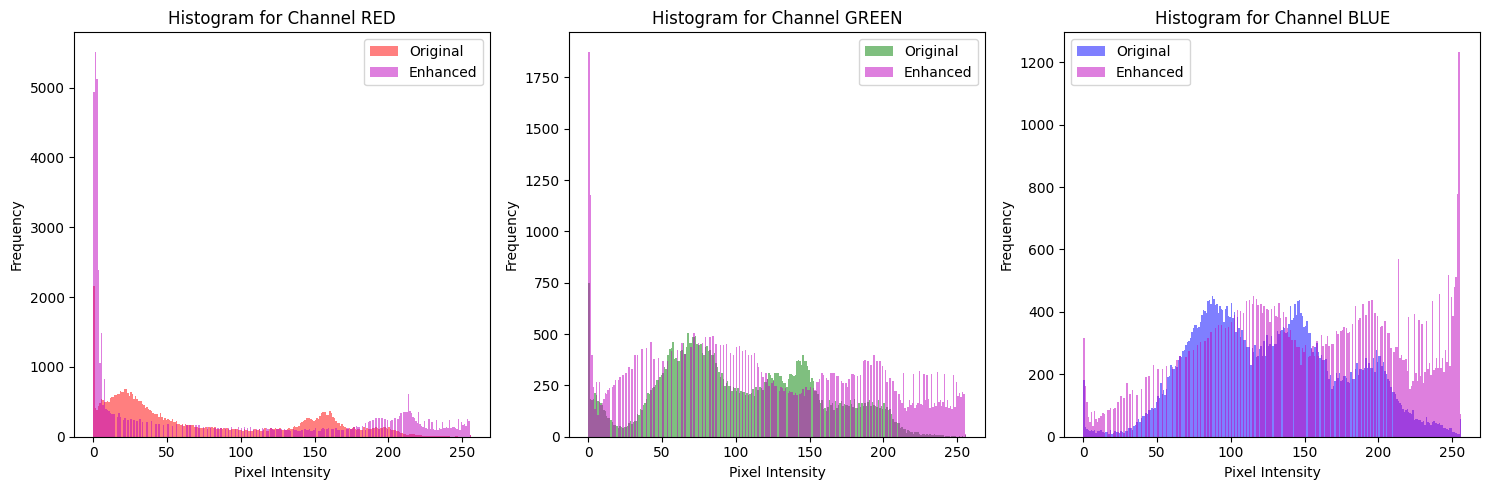

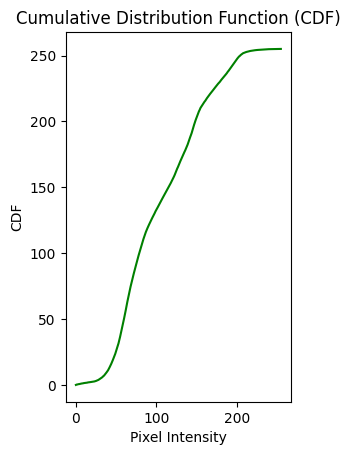

In [9]:
enhanced_image = contrast_enhancement(noisy_image, 1)

cv2.imshow('Contrasty image', enhanced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Canny Edge Detection

Firstly, the denoised and contrast-enhanced image has to be transformed to grayscale and than the edge detection algorithm can be applied to it.

__Preprocessing:__

In [8]:
denoised_image = median_filter(noisy_image, window_size)
enhanced_denoised_image = contrast_enhancement(denoised_image, 0)
gray_image_processed = colored_to_grayscale(enhanced_denoised_image)

__Edge Detection:__

In [9]:
edges = cv2.Canny(gray_image_processed, 100, 200)

cv2.imshow("Edges", edges)
cv2.waitKey(0)

-1

## Color-based Segmentation

In [12]:
# define color thresholds

# Red
lower_red1 = (0, 150, 150)
upper_red1 = (10, 255, 255)
lower_red2 = (165, 150, 150)
upper_red2 = (179, 255, 255)

# Blue
lower_blue = (90, 150, 150)
upper_blue = (120, 255, 255)

# Yellow
lower_yellow = (20, 150, 150)
upper_yellow = (35, 255, 255)

# Black
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_segmentation(image, window_size = None):
    # transform image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # create a mask for each color range
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_black = cv2.inRange(hsv_image, lower_black, upper_black)

    mask_red = mask_red1 | mask_red2

    if window_size is not None:
        window = np.ones(window_size, np.uint8)
    else:
        window = np.ones((3, 3), np.uint8)

    # TODO: rewrite opening and closing
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, window)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, window)
    
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, window)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, window)

    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, window)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, window)
    
    mask_black = cv2.morphologyEx(mask_black, cv2.MORPH_OPEN, window)
    mask_black = cv2.morphologyEx(mask_black, cv2.MORPH_CLOSE, window)

    # create a data frame with the masks
    dict = {
        'red': mask_red,
        'blue': mask_blue,
        'yellow': mask_yellow,
        'black': mask_black
    }


    return dict


In [13]:
color_signs = color_segmentation(enhanced_denoised_image)
cv2.imshow("After Color Segmentation", color_signs['red'])
cv2.waitKey(0)

-1

## Shape Detection

### Contour Drawing

In [14]:
def draw_contour(image):
    contour_image = np.zeros_like(image)
    offsets = [(i, j) for i in range(-1, 2) for j in range(-1, 2)]

    # leave 1 pixel for the offsets
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] != 0:
                for di, dj in offsets:
                    if image[i + di, j + dj] == 0:
                        contour_image[i, j] = 255
                        break

    return contour_image

In [15]:
contour_red = draw_contour(color_signs["red"])
cv2.imshow("Contours", contour_red)
cv2.waitKey(0)

-1